In [1]:
from emulator import *
from fisher_utils import *

Creating dndM interpolation


100%|██████████| 25/25 [01:54<00:00,  4.58s/it]


In [2]:
fiducial_dndM(1, 3)

array([[2.32777096e-13]])

In [52]:
z_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0]
richness_bin_edges = [20., 30., 45., 60., 300.]

In [4]:
N_fiducial = N_in_z_bins_and_richness_bins(fiducial_cosmology, richness_bin_edges, z_bin_edges)

100%|██████████| 4/4 [01:09<00:00, 17.43s/it]


In [5]:
cluster_count_cov = np.zeros((len(z_bin_edges) - 1, len(z_bin_edges) - 1, len(richness_bin_edges) - 1, len(richness_bin_edges) - 1))


In [6]:
halo_bias = ccl.halos.HaloBiasTinker10(fiducial_ccl_cosmo)

In [7]:
fiducial_h = fiducial_cosmology['H0']/100
halo_bias.get_halo_bias(fiducial_ccl_cosmo, 1e14 *  fiducial_h, 1) #[Mass] is Msun / h

1.5599995119337984

In [75]:
from scipy.integrate import quad, dblquad

def inner_integral(lam, M, z_val):
    p = cluster_richness_relation(M, lam, z_val)
    dn_dM = fiducial_dndM(z_val, M)
    bh = halo_bias.get_halo_bias(fiducial_ccl_cosmo, M * fiducial_h, 1./(1+z_val))
    return p * dn_dM  * bh

def outer_integral(z_val, lam_alpha_min, lam_alpha_max, lam_beta_min, lam_beta_max):
    integral_M_val, _ = dblquad(inner_integral, M_min, M_max, lam_alpha_min, lam_alpha_max,
                             args=(z_val,), 
                             epsrel=1e-4, epsabs=0)
    
    integral_M_prime_val, _ = dblquad(inner_integral, M_min, M_max, lam_beta_min, lam_beta_max,
                             args=(z_val,), 
                             epsrel=1e-4, epsabs=0)
    
    return Ωs_rad**2 * integral_M_val * integral_M_prime_val * comoving_volume_elements(z_val, tuple(fiducial_cosmo_vals))







In [76]:
all_bin_combos = [[i,j,a,b] for i in range(len(z_bin_edges) - 1) 
 for j in range(len(z_bin_edges) - 1) 
 for a in range(len(richness_bin_edges) - 1)
for b in range(len(richness_bin_edges) - 1)]


for i,j,a,b in tqdm(all_bin_combos):
    zi_min = z_bin_edges[i]
    zi_max = z_bin_edges[i + 1]
    zj_min = z_bin_edges[j]
    zj_max = z_bin_edges[j + 1]
    #from Eq(6) of Krause+17, it seems like supersample variance only
    #when the redshift bins overlap. so we can ignore when
    #zi != zj
    if(i != j):
        continue
    la_min = richness_bin_edges[a]
    la_max = richness_bin_edges[a + 1]
    lb_min = richness_bin_edges[b]
    lb_max = richness_bin_edges[b + 1]
    result, error = quad(outer_integral, 
                         zi_min, zi_max, 
                         args=(la_min, la_max, 
                               lb_min, lb_max),
                        epsrel=1e-4, epsabs=0)
    cluster_count_cov[i,j,a,b] = result 
    if(i == j and a == b): #shot noise
        cluster_count_cov[i,j,a,b] +=  N_fiducial[i][a]


100%|██████████| 256/256 [20:55<00:00,  4.90s/it] 


In [77]:
cluster_count_cov

array([[[[1.15773242e+04, 1.32402010e+00, 6.06884350e-01,
          9.95395982e-01],
         [1.32402010e+00, 6.30451923e+03, 3.84388934e-01,
          6.30862346e-01],
         [6.06884350e-01, 3.84388934e-01, 2.51646600e+03,
          2.89521701e-01],
         [9.95395982e-01, 6.30862346e-01, 2.89521701e-01,
          3.24320810e+03]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
   

In [78]:
n_z = len(z_bin_edges) - 1
n_r = len(richness_bin_edges) - 1
cov_matrix_2d = np.zeros((n_z * n_r, n_z * n_r))

for i in range(n_z):
    for j in range(n_z):
        for a in range(n_r):
            for b in range(n_r):
                row_index = i * n_r + a
                col_index = j * n_r + b
                cov_matrix_2d[row_index, col_index] = cluster_count_cov[i, j, a, b]


/tmp/ipykernel_19584/1281945031.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(cov_matrix_2d), cmap='rainbow')


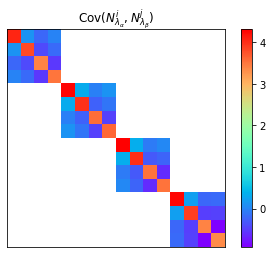

In [92]:
import matplotlib.pyplot as plt

plt.imshow(np.log10(cov_matrix_2d), cmap='rainbow')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title(r'${\rm Cov}(N^i_{\lambda_\alpha} , N^j_{\lambda_\beta})$')
plt.show()

In [81]:
M_numerics = np.linspace(M_min, M_max, 100)
halo_bias.get_halo_bias(fiducial_ccl_cosmo, M_numerics *  fiducial_h, 1./(1+0.2)) #[Mass] is Msun / h

array([  0.68907091,   4.57692662,   6.57230449,   8.27767822,
         9.83365539,  11.29460114,  12.68838688,  14.03157026,
        15.33493703,  16.60597498,  17.8501348 ,  19.07153003,
        20.27335576,  21.4581555 ,  22.62799098,  23.78455954,
        24.92927801,  26.06334331,  27.18777718,  28.30345976,
        29.41115181,  30.51151453,  31.60513008,  32.69251436,
        33.77412697,  34.8503794 ,  35.92164172,  36.98824811,
        38.0505015 ,  39.10867745,  40.16302747,  41.2137818 ,
        42.26115326,  43.30534731,  44.34655729,  45.38496196,
        46.42072694,  47.454006  ,  48.48494218,  49.51366878,
        50.54031026,  51.564983  ,  52.58779599,  53.60885146,
        54.62824546,  55.64606831,  56.66240507,  57.67733597,
        58.69093673,  59.70327894,  60.71443031,  61.72445497,
        62.73341375,  63.74136327,  64.74834785,  65.75440455,
        66.7595686 ,  67.76387351,  68.76735119,  69.77003208,
        70.77194518,  71.7731182 ,  72.7735776 ,  73.77

In [83]:
from scipy.integrate import dblquad
def inner_cluster_count_integrand(lam, M, z_val=0):
    p = cluster_richness_relation(M, lam, z_val) # h / Msun

    dn_dM = fiducial_dndM(z_val, M) # h^4 / (Mpc^3  Msun)

    return p * dn_dM  # h / (Msun)
dblquad(inner_cluster_count_integrand, M_min, M_max, 20, 30, epsrel=1e-4, epsabs=0)

(8.963540604845908e-06, 1.3531209359172206e-10)

In [84]:
dblquad(inner_integral, M_min, M_max, 20, 30, args=(0.0,), epsrel=1e-4, epsabs=0)

(1.5968564722583244e-05, 2.2851423546713124e-10)

In [86]:
import pickle
    
with open('cluster_abundance_fiducial_covariance.pkl', 'wb') as file:
        pickle.dump(cluster_count_cov, file)

array([[ 8.63757505e-05, -1.81359593e-08, -2.08250166e-08,
        -2.65048069e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.81359593e-08,  1.58616386e-04, -2.42206516e-08,
        -3.08460133e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.08250166e-08, -2.42206516e-08,  3.97382691e-04,
        -3.54633130e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.65048069e-08, -3.08460133e

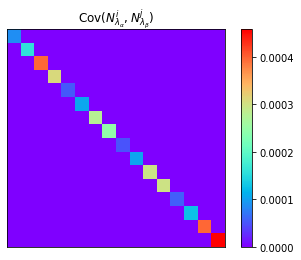

In [90]:
import matplotlib.pyplot as plt

plt.imshow((np.linalg.inv(cov_matrix_2d)), cmap='rainbow')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title(r'${\rm Cov}(N^i_{\lambda_\alpha} , N^j_{\lambda_\beta})$')
plt.show()